In [32]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import shutil
import os

In [33]:
image_path = '0001.jpg'
image = cv2.imread(image_path)

Shape of image array: (480, 640, 3)


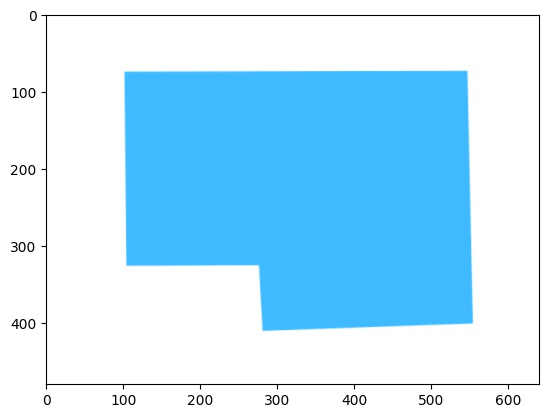

In [34]:
if image is not None:
    image_array = np.array(image)
    
    print("Shape of image array:", image_array.shape)
    
    plt.imshow(image)
    plt.show()
else:
    print("Failed to load the image.")

In [35]:
image_array[300][200]

array([ 64, 186, 255], dtype=uint8)

In [36]:
def getRectangle(image_path):
    image = cv2.imread(image_path)
    # Define range for yellow color in RGB
    lower_yellow = np.array([30, 150, 200])  # Lower range for yellow in RGB
    upper_yellow = np.array([100, 220, 255])  # Upper range for yellow in RGB

    # Threshold the image to get only yellow colors
    mask = cv2.inRange(image, lower_yellow, upper_yellow)

    # Find contours in the binary mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours)==1:
        contour = contours[0]
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = np.intp(box)
        
        # Draw the bounding rectangle on the original image
        cv2.drawContours(image, [box], 0, (0, 255, 0), 2)
        
        # Save or display the image with bounding rectangles
        cv2.imwrite(f'Bounded-images/r_{image_path[-8:]}', image)
        return rect[1]
    else:
        print(f"{len(contours)} contours found in {image_path}.")

In [37]:
df = pd.DataFrame()
image_paths = []
for i in range(1,1184):
    image_path = "E7-images/" + "0"*(4-len(str(i))) + str(i) + ".jpg"
    image_paths.append(image_path)
df['Image path'] = image_paths
df.head()

,Image path
0,E7-images/0001.jpg
1,E7-images/0002.jpg
2,E7-images/0003.jpg
3,E7-images/0004.jpg
4,E7-images/0005.jpg


In [38]:
width = []
height= []
for item in df['Image path']:
    w, h = getRectangle(item)
    width.append(w)
    height.append(h)
df['Width'] = width
df['Height'] = height
df.head()

,Image path,Width,Height
0,E7-images/0001.jpg,335.983185,448.007599
1,E7-images/0002.jpg,335.000000,449.000000
2,E7-images/0003.jpg,319.825775,452.727631
3,E7-images/0004.jpg,316.791534,460.062500
4,E7-images/0005.jpg,455.249207,331.149445


In [39]:
def extract_features(image_path):
    # Load the image
    image = cv2.imread(image_path)
    
    lower_yellow = np.array([30, 150, 200]) 
    upper_yellow = np.array([100, 220, 255]) 

    mask = cv2.inRange(image, lower_yellow, upper_yellow)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate the area of the largest contour
    if len(contours) == 1:
        moments = cv2.moments(contours[0])
        hu_moments = cv2.HuMoments(moments).flatten()
        return hu_moments, cv2.contourArea(contours[0])
    else:
        print(f"{len(contours)} contours found in {image_path}")
        return None, None

# Example usage
image_path = '0001.jpg'
hu_moments, area = extract_features(image_path)
print(f"Hu Moments: {hu_moments}")
print(f"Area: {area}")


Hu Moments: [1.80386358e-01 4.19941787e-03 3.40938168e-04 9.85549883e-06
 5.70502266e-10 6.30203170e-07 2.99680425e-11]
Area: 132977.5


## Hu Moments
Hu Moments, also known as the Hu invariant moments, are a set of seven numbers calculated from the central moments that are invariant to image transformations such as translation, scale, and rotation. These moments are particularly useful for shape-based image analysis and object recognition, as they capture the **shape characteristics** of an object while being insensitive to changes in position, size, and orientation.

C:\Users\Vishwam\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Vishwam\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Vishwam\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Vishwam\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: 

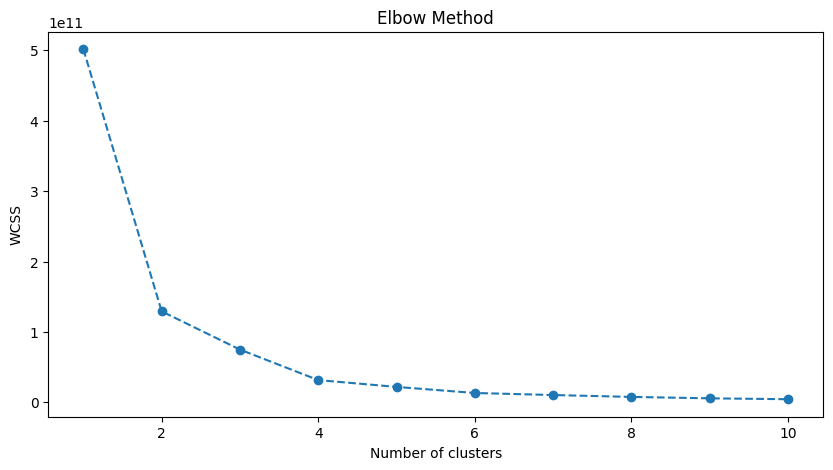

In [40]:
# List to store feature vectors
feature_vectors = []

# List to store image paths
image_paths = []

# Loop through each image in the directory
for i in range(1,1184):
    image_path = "E7-images/"+ "0"*(4-len(str(i))) + str(i) + ".jpg"
    image_paths.append(image_path)
    hu_moments, area = extract_features(image_path)
    if hu_moments is not None and area is not None:
        feature_vector = list(hu_moments) + [area]
        feature_vectors.append(feature_vector)

# Convert feature vectors to NumPy array
feature_vectors = np.array(feature_vectors)

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(feature_vectors)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

C:\Users\Vishwam\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Vishwam\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Vishwam\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Vishwam\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: 

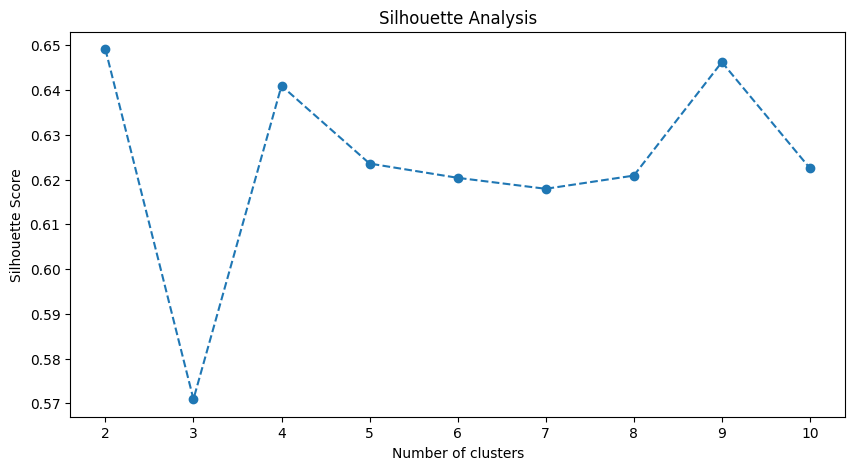

In [41]:
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(feature_vectors)
    score = silhouette_score(feature_vectors, kmeans.labels_)
    silhouette_scores.append(score)

# Plot the Silhouette Analysis graph
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Analysis')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [42]:
df.to_csv('test.csv')

## Vertices

In [49]:
def getFeatures(image_path):
    image = cv2.imread(image_path)
    
    # Threshold the image to get a binary mask
    lower_yellow = np.array([30, 150, 200]) 
    upper_yellow = np.array([100, 220, 255]) 

    mask = cv2.inRange(image, lower_yellow, upper_yellow)

    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)


    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Extract the largest contour
    if len(contours) > 0:
        polygon_contour = max(contours, key=cv2.contourArea)

        epsilon = 0.01 * cv2.arcLength(polygon_contour, True)
        approx = cv2.approxPolyDP(polygon_contour, epsilon, True)
        
        # Compute metrics
        perimeter = cv2.arcLength(approx, True)
        area = cv2.contourArea(approx)
        convex_hull = cv2.convexHull(approx)
        convexity = area / cv2.contourArea(convex_hull)
        moments = cv2.moments(approx)
        hu_moments = cv2.HuMoments(moments).flatten()
        
        for vertex in approx:
            x, y = vertex[0]
            cv2.circle(image, (x, y), 5, (255, 0, 0), -1)  # Draw a blue circle
        # plt.imshow(image)
        # plt.show()

        # Print metrics
        # print(f"Number of Vertices: {len(approx)}")
        # print(f"Perimeter: {perimeter}")
        # print(f"Area: {area}")
        # print(f"Convexity: {convexity}")
        # print(f"Hu Moments: {hu_moments}")

        return len(approx), perimeter, area, convexity, hu_moments
        
    else:
        print("No contours found.")

In [50]:
getFeatures('E7-images/0641.jpg')

(8,
 1263.2855987548828,
 106580.0,
 1.0,
 array([ 1.70870018e-01,  2.07408711e-03,  5.00236636e-04,  8.82366590e-06,
         2.17974041e-10,  1.58934622e-07, -5.44189594e-10]))

In [51]:
vertices = []
perimeters = []
areas = []
convexities = []
hu_moment = []

for path in df['Image path']:
    v, p, a, c, m = getFeatures(path)
    vertices.append(v)
    perimeters.append(p)
    areas.append(a)
    convexities.append(c)
    hu_moment.append(m)

df['Vertices'] = vertices
df['Perimeter'] = perimeters
df['Area'] = areas
df['Convexity'] = convexities
df['Hu Moments'] = hu_moment

In [52]:
df.head()

,Image path,Width,Height,Vertices,Perimeter,Area,Convexity,Hu Moments
0,E7-images/0001.jpg,335.983185,448.007599,6,1541.454628,132497.5,0.948603,"[0.18026969291114103, 0.0041782253904490765, 0..."
1,E7-images/0002.jpg,335.000000,449.000000,5,1437.618256,129795.5,1.000000,"[0.1696461865785461, 0.0011544008014114945, 0...."
2,E7-images/0003.jpg,319.825775,452.727631,6,1298.134338,103262.5,0.949820,"[0.18091767657435048, 0.005241593848098717, 0...."
3,E7-images/0004.jpg,316.791534,460.062500,7,1381.235241,99502.5,0.925648,"[0.19568137201449717, 0.008291008695238338, 0...."
4,E7-images/0005.jpg,455.249207,331.149445,5,1523.534454,144885.0,1.000000,"[0.17387221369674163, 0.00273347232838232, 8.8..."


In [53]:
# Circularity
df['Circularity'] = 4*3.14*df['Area']/(df['Perimeter']*df['Perimeter'])

In [54]:
df.head()

,Image path,Width,Height,Vertices,Perimeter,Area,Convexity,Hu Moments,Circularity
0,E7-images/0001.jpg,335.983185,448.007599,6,1541.454628,132497.5,0.948603,"[0.18026969291114103, 0.0041782253904490765, 0...",0.700383
1,E7-images/0002.jpg,335.000000,449.000000,5,1437.618256,129795.5,1.000000,"[0.1696461865785461, 0.0011544008014114945, 0....",0.788791
2,E7-images/0003.jpg,319.825775,452.727631,6,1298.134338,103262.5,0.949820,"[0.18091767657435048, 0.005241593848098717, 0....",0.769650
3,E7-images/0004.jpg,316.791534,460.062500,7,1381.235241,99502.5,0.925648,"[0.19568137201449717, 0.008291008695238338, 0....",0.655071
4,E7-images/0005.jpg,455.249207,331.149445,5,1523.534454,144885.0,1.000000,"[0.17387221369674163, 0.00273347232838232, 8.8...",0.783986


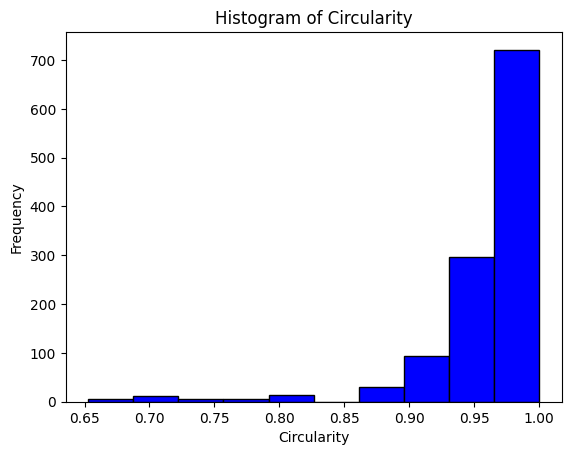

In [55]:
# Histogram of column 'A'
plt.hist(df['Convexity'], bins=10, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('Circularity')
plt.ylabel('Frequency')
plt.title('Histogram of Circularity')

# Display the histogram
plt.show()

In [56]:
df['Area_Normalized'] = (df['Area'] - df['Area'].min()) / (df['Area'].max() - df['Area'].min())
df['Perimeter_Normalized'] = (df['Perimeter'] - df['Perimeter'].min()) / (df['Perimeter'].max() - df['Perimeter'].min())
df['Vertices_Normalized'] = (df['Vertices'] - df['Vertices'].min()) / (df['Vertices'].max() - df['Vertices'].min())


In [57]:
df['Complexity'] = 1 - df['Area']/(df['Width']*df['Height'])
df.head()

,Image path,Width,Height,Vertices,Perimeter,Area,Convexity,Hu Moments,Circularity,Area_Normalized,Perimeter_Normalized,Vertices_Normalized,Complexity
0,E7-images/0001.jpg,335.983185,448.007599,6,1541.454628,132497.5,0.948603,"[0.18026969291114103, 0.0041782253904490765, 0...",0.700383,0.779106,0.927882,0.333333,0.119753
1,E7-images/0002.jpg,335.000000,449.000000,5,1437.618256,129795.5,1.000000,"[0.1696461865785461, 0.0011544008014114945, 0....",0.788791,0.744825,0.622830,0.222222,0.137084
2,E7-images/0003.jpg,319.825775,452.727631,6,1298.134338,103262.5,0.949820,"[0.18091767657435048, 0.005241593848098717, 0....",0.769650,0.408200,0.213051,0.333333,0.286831
3,E7-images/0004.jpg,316.791534,460.062500,7,1381.235241,99502.5,0.925648,"[0.19568137201449717, 0.008291008695238338, 0....",0.655071,0.360496,0.457187,0.444444,0.317278
4,E7-images/0005.jpg,455.249207,331.149445,5,1523.534454,144885.0,1.000000,"[0.17387221369674163, 0.00273347232838232, 8.8...",0.783986,0.936267,0.875236,0.222222,0.038941


In [58]:
df['Hu Moments'][0]

array([1.80269693e-01, 4.17822539e-03, 3.46303298e-04, 9.76335601e-06,
       5.66672026e-10, 6.21769433e-07, 3.43240297e-11])

In [59]:
# Explode the lists into separate columns
df_hu = df['Hu Moments'].apply(pd.Series)
df_hu.columns = ['Hu Moment ' + str(i) for i in range(1, 8)]

# Concatenate the expanded columns to the original DataFrame
df_expanded = pd.concat([df, df_hu], axis=1)
df_expanded.drop('Hu Moments', axis=1, inplace=True)  # Drop the original 'Feature1' column

df_expanded.head()


,Image path,Width,Height,Vertices,Perimeter,Area,Convexity,Circularity,Area_Normalized,Perimeter_Normalized,Vertices_Normalized,Complexity,Hu Moment 1,Hu Moment 2,Hu Moment 3,Hu Moment 4,Hu Moment 5,Hu Moment 6,Hu Moment 7
0,E7-images/0001.jpg,335.983185,448.007599,6,1541.454628,132497.5,0.948603,0.700383,0.779106,0.927882,0.333333,0.119753,0.180270,0.004178,0.000346,9.763356e-06,5.666720e-10,6.217694e-07,3.432403e-11
1,E7-images/0002.jpg,335.000000,449.000000,5,1437.618256,129795.5,1.000000,0.788791,0.744825,0.622830,0.222222,0.137084,0.169646,0.001154,0.000126,2.745398e-06,-5.106724e-11,-9.326173e-08,2.018437e-12
2,E7-images/0003.jpg,319.825775,452.727631,6,1298.134338,103262.5,0.949820,0.769650,0.408200,0.213051,0.333333,0.286831,0.180918,0.005242,0.000218,1.264968e-05,3.777292e-10,7.032677e-07,-5.465550e-10
3,E7-images/0004.jpg,316.791534,460.062500,7,1381.235241,99502.5,0.925648,0.655071,0.360496,0.457187,0.444444,0.317278,0.195681,0.008291,0.001047,1.202782e-04,4.159451e-08,8.631942e-06,-9.537261e-09
4,E7-images/0005.jpg,455.249207,331.149445,5,1523.534454,144885.0,1.000000,0.783986,0.936267,0.875236,0.222222,0.038941,0.173872,0.002733,0.000009,2.209555e-07,1.422379e-13,-9.221629e-09,-2.743454e-13


In [60]:
# Select columns to normalize
columns_to_normalize = [f'Hu Moment {i}' for i in range(1,8)]

scaler = MinMaxScaler()

df_expanded[columns_to_normalize] = scaler.fit_transform(df_expanded[columns_to_normalize])

df_expanded.head()


,Image path,Width,Height,Vertices,Perimeter,Area,Convexity,Circularity,Area_Normalized,Perimeter_Normalized,Vertices_Normalized,Complexity,Hu Moment 1,Hu Moment 2,Hu Moment 3,Hu Moment 4,Hu Moment 5,Hu Moment 6,Hu Moment 7
0,E7-images/0001.jpg,335.983185,448.007599,6,1541.454628,132497.5,0.948603,0.700383,0.779106,0.927882,0.333333,0.119753,0.130874,0.123744,0.064004,0.026492,0.249174,0.509772,0.146867
1,E7-images/0002.jpg,335.000000,449.000000,5,1437.618256,129795.5,1.000000,0.788791,0.744825,0.622830,0.222222,0.137084,0.023206,0.023596,0.023327,0.007449,0.248241,0.498273,0.146761
2,E7-images/0003.jpg,319.825775,452.727631,6,1298.134338,103262.5,0.949820,0.769650,0.408200,0.213051,0.333333,0.286831,0.137441,0.158963,0.040302,0.034323,0.248889,0.511083,0.144959
3,E7-images/0004.jpg,316.791534,460.062500,7,1381.235241,99502.5,0.925648,0.655071,0.360496,0.457187,0.444444,0.317278,0.287070,0.259958,0.193435,0.326361,0.311148,0.638589,0.115420
4,E7-images/0005.jpg,455.249207,331.149445,5,1523.534454,144885.0,1.000000,0.783986,0.936267,0.875236,0.222222,0.038941,0.066037,0.075895,0.001632,0.000599,0.248318,0.499625,0.146754


In [61]:
# Initialize K-means clustering
kmeans = KMeans(n_clusters=9, random_state=42)  # Specify the number of clusters
features = ['Vertices_Normalized', 'Convexity', 'Circularity', 'Complexity'] + [f'Hu Moment {i}' for i in range(1,8)]

# Fit K-means clustering to the DataFrame
kmeans.fit(df_expanded[features])

# Add cluster labels to the DataFrame
df_expanded['Cluster'] = kmeans.labels_

df_expanded.head()


C:\Users\Vishwam\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Image path,Width,Height,Vertices,Perimeter,Area,Convexity,Circularity,Area_Normalized,Perimeter_Normalized,Vertices_Normalized,Complexity,Hu Moment 1,Hu Moment 2,Hu Moment 3,Hu Moment 4,Hu Moment 5,Hu Moment 6,Hu Moment 7,Cluster
0,E7-images/0001.jpg,335.983185,448.007599,6,1541.454628,132497.5,0.948603,0.700383,0.779106,0.927882,0.333333,0.119753,0.130874,0.123744,0.064004,0.026492,0.249174,0.509772,0.146867,6
1,E7-images/0002.jpg,335.000000,449.000000,5,1437.618256,129795.5,1.000000,0.788791,0.744825,0.622830,0.222222,0.137084,0.023206,0.023596,0.023327,0.007449,0.248241,0.498273,0.146761,0
2,E7-images/0003.jpg,319.825775,452.727631,6,1298.134338,103262.5,0.949820,0.769650,0.408200,0.213051,0.333333,0.286831,0.137441,0.158963,0.040302,0.034323,0.248889,0.511083,0.144959,6
3,E7-images/0004.jpg,316.791534,460.062500,7,1381.235241,99502.5,0.925648,0.655071,0.360496,0.457187,0.444444,0.317278,0.287070,0.259958,0.193435,0.326361,0.311148,0.638589,0.115420,5
4,E7-images/0005.jpg,455.249207,331.149445,5,1523.534454,144885.0,1.000000,0.783986,0.936267,0.875236,0.222222,0.038941,0.066037,0.075895,0.001632,0.000599,0.248318,0.499625,0.146754,0


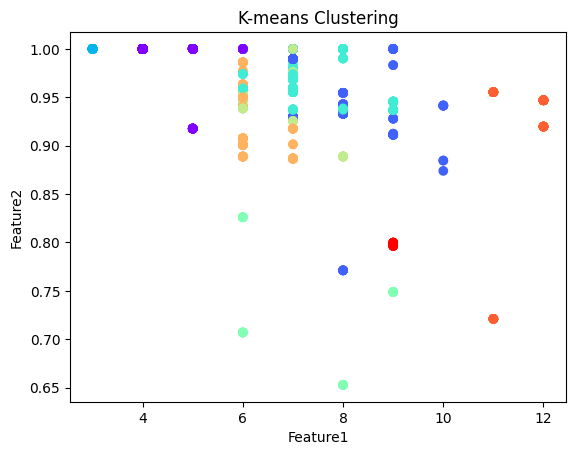

In [62]:
# Scatter plot of the clusters (using Feature1 and Feature2)
plt.scatter(df_expanded['Vertices'], df_expanded['Convexity'], c=df_expanded['Cluster'], cmap='rainbow')
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.title('K-means Clustering')
plt.show()


In [63]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score
silhouette_avg = silhouette_score(df_expanded[features], kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.4473223606927649


In [64]:
cluster_dfs = []
for i in range(9):
    cluster_dfs.append(df_expanded[df_expanded['Cluster']==i]) 


In [ ]:
for i in range(9):
    for index, row in cluster_dfs[i].iterrows():
        image_path = row['Image path']
        image_filename = os.path.basename(image_path)
        
        source_dir = "C:/Users/Vishwam/Desktop/DS203/E7/E7-images/"
        dest_dir = f"C:/Users/Vishwam/Desktop/DS203/E7/Clusters/{i+1}/"
        # Define the source and destination paths
        src_path = os.path.join(source_dir, image_filename)
        dest_path = os.path.join(dest_dir, image_filename)
        
        # Copy the image from source to destination
        shutil.copy(src_path, dest_path)